# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
#Скачиваем библиотеку sqlalchemy
!pip install sqlalchemy 

In [3]:
# подключаем библиотеки для выгрузки данных и их обработки
import pandas as pd
from sqlalchemy import create_engine
import matplotlib as plt
import numpy as np

In [4]:
#создание подключения к БД
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название
             }

#перевод данных из словаря в строку
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

In [5]:
#создание запроса и считывание данных
query ="""
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,  -- берём из purchases, как указано в схеме
    c.city_name,
    r.region_name
FROM afisha.purchases AS p
JOIN afisha.events AS e
    ON p.event_id = e.event_id
JOIN afisha.city AS c
    ON e.city_id = c.city_id
JOIN afisha.regions AS r
    ON c.region_id = r.region_id
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
"""

df = pd.read_sql_query(query, con=engine) 

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Чтож перед нами очень хороший набор данных с ~ 30_000 строк. В нём из 15 столбцов только в days_since_prev есть пропуски и то они обозначают первую покупку данного человека (т.е. несут в себе информацию). Из-за того что у нас выручка представленна в разных валютах потребуется унификация. Также обзательный пункт проверка на дубликаты явные и не явные названия мероприятий можно перевести в тип string а в device_type_canonical всего 2 варианта значений mobail и desctop что можно преобразоватьв bool 0 и 1 соответственно, days_since_prev в int. order_dt в date

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [7]:
#Выполним перевод в нужные нам типы данных
spi = ['region_name','city_name','user_id','device_type_canonical', 'event_name','order_id', 'currency_code', 'event_id', 'event_type_main', 'service_name']
df[spi] = df[spi].astype('string', errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  string        
 1   device_type_canonical  290611 non-null  string        
 2   order_id               290611 non-null  string        
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  string        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  string        
 10  event_name             290611 non-null  string        
 11  event_type_main        290611 non-null  string        
 12  service_name           290611 non-null  stri

In [8]:
s = ['device_type_canonical', 'order_dt','order_ts','currency_code','revenue','tickets_count','event_id','event_type_main','service_name','city_name', 'region_name']

print(f"Количество неявных дубликатов {df.duplicated(subset=s).sum()}")
print(f"Доля неявных дубликатов {df.duplicated(subset=s).sum()/290611} < 1%")

Количество неявных дубликатов 310
Доля неявных дубликатов 0.0010667180526545794 < 1%


In [9]:
#избавимся от дубликатов
df = df.drop_duplicates(subset = s)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290301 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290301 non-null  string        
 1   device_type_canonical  290301 non-null  string        
 2   order_id               290301 non-null  string        
 3   order_dt               290301 non-null  datetime64[ns]
 4   order_ts               290301 non-null  datetime64[ns]
 5   currency_code          290301 non-null  string        
 6   revenue                290301 non-null  float64       
 7   tickets_count          290301 non-null  int64         
 8   days_since_prev        268373 non-null  float64       
 9   event_id               290301 non-null  string        
 10  event_name             290301 non-null  string        
 11  event_type_main        290301 non-null  string        
 12  service_name           290301 non-null  stri

In [10]:
#проведение унификации валюты нужно производить переводсогласно курсу в момент покупки билета
Kurs = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
print(Kurs)

           data  nominal     curs  cdx
0    2024-01-10      100  19.9391  kzt
1    2024-01-11      100  19.7255  kzt
2    2024-01-12      100  19.5839  kzt
3    2024-01-13      100  19.4501  kzt
4    2024-01-14      100  19.4501  kzt
..          ...      ...      ...  ...
352  2024-12-27      100  19.2705  kzt
353  2024-12-28      100  19.5105  kzt
354  2024-12-29      100  19.4860  kzt
355  2024-12-30      100  19.4860  kzt
356  2024-12-31      100  19.4860  kzt

[357 rows x 4 columns]


In [11]:
#поскольку курс представлен для перевода в 100 рублей формула будет следующей
# выручка * курс в этот день / 100
def perevod(x):
    if x['currency_code'] == 'kzt':
        kurs_row = Kurs[Kurs['data'] == x['order_dt']]
        if not kurs_row.empty:
            # Извлекаем конкретное значение курса, а не Series
            kurs = kurs_row['curs'].iloc[0]
            return kurs * x['revenue'] / 100
        else:
            # Если курс не найден, возвращаем исходное значение
            return x['revenue']
    return x['revenue']

df['revenue_rub'] = df.apply(perevod, axis=1)

In [12]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край,1390.41


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Ранее выяснилось что пропуски присутствуют только в столбце days_since_prev. Поэтому перейдём к преобразованию типов данных

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290301 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290301 non-null  string        
 1   device_type_canonical  290301 non-null  string        
 2   order_id               290301 non-null  string        
 3   order_dt               290301 non-null  datetime64[ns]
 4   order_ts               290301 non-null  datetime64[ns]
 5   currency_code          290301 non-null  string        
 6   revenue                290301 non-null  float64       
 7   tickets_count          290301 non-null  int64         
 8   days_since_prev        268373 non-null  float64       
 9   event_id               290301 non-null  string        
 10  event_name             290301 non-null  string        
 11  event_type_main        290301 non-null  string        
 12  service_name           290301 non-null  stri

Для days_since_prev int32,для tickets_count int64 так как количество купленных билетов должно быть натуральным числом

In [14]:
df['days_since_prev'] = pd.to_numeric(df['days_since_prev'])
df['tickets_count'] = pd.to_numeric(df['tickets_count'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290301 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290301 non-null  string        
 1   device_type_canonical  290301 non-null  string        
 2   order_id               290301 non-null  string        
 3   order_dt               290301 non-null  datetime64[ns]
 4   order_ts               290301 non-null  datetime64[ns]
 5   currency_code          290301 non-null  string        
 6   revenue                290301 non-null  float64       
 7   tickets_count          290301 non-null  int64         
 8   days_since_prev        268373 non-null  float64       
 9   event_id               290301 non-null  string        
 10  event_name             290301 non-null  string        
 11  event_type_main        290301 non-null  string        
 12  service_name           290301 non-null  stri

Хорошо, теперь проверим значения в критических столбцах

In [15]:
print('Показатели поля revenue')
print(df['revenue'].describe())
print(f"99 процентиль = {df['revenue'].quantile(0.99)}")

print('\n\nПоказатели поля tickets_count')
print(df['tickets_count'].describe())
print(f"99 процентиль = {df['tickets_count'].quantile(0.99)}")

Показатели поля revenue
count    290301.000000
mean        625.912659
std        1227.259022
min         -90.760000
25%         116.990000
50%         356.830000
75%         810.410000
max       81174.540000
Name: revenue, dtype: float64
99 процентиль = 4000.19


Показатели поля tickets_count
count    290301.000000
mean          2.754238
std           1.170761
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64
99 процентиль = 6.0


<AxesSubplot:>

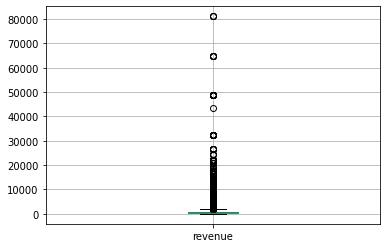

In [16]:
df[['revenue']].boxplot()

<AxesSubplot:>

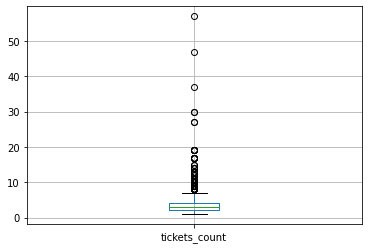

In [17]:
df[['tickets_count']].boxplot()

Из полученных данных видно следующее: 
Поле revenue:
- Есть отрицательные значения которые в нашей задаче будут только мешать анализу
- около 1 процента клиентов покупают билеты на сумму свыше 4000 руб. возможно это коллективные покупки оформленные на одного человека, ошибкой не является но для дальнейшего анализа придётся от них тоже избавиться

Поле tickets_count:
- В целом данные подозрений не вызывают, концентрация данных идёт до отметки 20 билетов, дальше еденичные случаи.

In [18]:
df = df.drop(df[(df['revenue'] <=0) | (df['revenue'] > 4000.19)].index)
df =df.drop(df[(df['tickets_count'] > 20)].index)

In [19]:
print(df['revenue'].describe())

count    281547.000000
mean        549.671762
std         564.694694
min           0.020000
25%         125.770000
50%         362.670000
75%         805.305000
max        4000.190000
Name: revenue, dtype: float64


<AxesSubplot:>

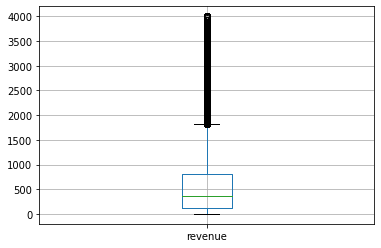

In [20]:
df[['revenue']].boxplot()

<AxesSubplot:>

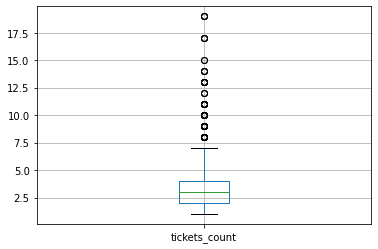

In [21]:
df[['tickets_count']].boxplot()

Чтож тепперь критически важные поля `'причёсаны'` теперь займёмся нормализацией строковых данных 

In [22]:
df['service_name'].unique()

<StringArray>
[          'Край билетов',              'Мой билет',            'За билетом!',
            'Лови билет!',     'Билеты без проблем',                'Облачко',
          'Лучшие билеты',              'Прачечная',            'Быстробилет',
           'Дом культуры',         'Весь в билетах',          'Билеты в руки',
            'Тебе билет!',            'Show_ticket', 'Городской дом культуры',
                 'Яблоко',      'Билет по телефону',         'Выступления.ру',
               'Росбилет',        'Шоу начинается!',               'Мир касс',
              'Восьмёрка',              'Телебилет',          'Crazy ticket!',
                 'Реестр',         'Быстрый кассир',             'КарандашРУ',
           'Радио ticket',                'Дырокол',                'Вперёд!',
             'Кино билет',           'Цвет и билет',               'Зе Бест!',
              'Тех билет',                 'Лимоны',     'Билеты в интернете']
Length: 36, dtype: string

Видно что среди значений service_name неявных дубликатов нет

In [23]:
# проверка на уникальность если order_id = длинне df то в каждой строке уникальный id заказа 
print(df['order_id'].nunique())
print(len(df['order_id']))

281547
281547


---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [24]:
#Проводим сортировку
df = df.sort_values(['user_id', 'order_ts'])

Дальнейшая идея состоит в создании сводной таблицы на основе данных из df

In [25]:
# Создаем профиль пользователя
user_profile = df.groupby('user_id').agg(
    first_order_dt=('order_dt', 'min'),  # дата первого заказа
    last_order_dt=('order_dt', 'max'),   # дата последнего заказа
    first_device=('device_type_canonical', 'first'),  # устройство первого заказа
    first_region=('region_name', 'first'),  # регион первого заказа
    first_service=('service_name', 'first'),  # билетный партнер первого заказа
    first_event_type=('event_type_main', 'first'),  # жанр первого мероприятия
    total_orders=('order_id', 'count'),  # общее количество заказов
    avg_revenue_rub=('revenue_rub', 'mean'),  # средняя выручка в рублях
    avg_tickets=('tickets_count', 'mean'),  # среднее количество билетов
    avg_days_between=('days_since_prev', 'mean')  # среднее время между заказами
).reset_index()

# Добавляем бинарные признаки
user_profile['is_two'] = ((user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

# Просмотрим результат
print(f"Всего пользователей: {len(user_profile)}")
user_profile.head()


Всего пользователей: 21608


,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets,avg_days_between,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


In [26]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21608 entries, 0 to 21607
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           21608 non-null  object        
 1   first_order_dt    21608 non-null  datetime64[ns]
 2   last_order_dt     21608 non-null  datetime64[ns]
 3   first_device      21608 non-null  string        
 4   first_region      21608 non-null  string        
 5   first_service     21608 non-null  string        
 6   first_event_type  21608 non-null  string        
 7   total_orders      21608 non-null  int64         
 8   avg_revenue_rub   21608 non-null  float64       
 9   avg_tickets       21608 non-null  float64       
 10  avg_days_between  13423 non-null  float64       
 11  is_two            21608 non-null  int64         
 12  is_five           21608 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(3), object(1), string(4)
memory usag

Иногда avg_days_between имеет значение  Nan что означет наличие только 1 заказа. Для поля user_id нужно поставить тип данных string. 

In [27]:
user_profile['user_id'] = user_profile['user_id'].astype("string")

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [28]:
print(f"Всего пользователей: {len(user_profile)}")
print(f"Cредняя выручка с одного заказа:", user_profile["avg_revenue_rub"].mean())

print(f"Доля пользователей, совершивших 2 и более заказа: {len(user_profile[user_profile['is_two']==1])/len(user_profile)}")
print(f"Доля пользователей, совершивших 5 и более заказа: {len(user_profile[user_profile['is_five']==1])/len(user_profile)}")

Всего пользователей: 21608
Cредняя выручка с одного заказа: 583.0615699367887
Доля пользователей, совершивших 2 и более заказа: 0.3276564235468345
Доля пользователей, совершивших 5 и более заказа: 0.2896149574231766


Из данных видно что более 60% пользователей совершали более 1 покупки. На удивление пользователей с 5 и более заказами не сильно меньше чем с 2,3,4 заказами.

In [29]:
user_profile['total_orders'].describe()

count    21608.000000
mean        13.029757
std        120.169466
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10013.000000
Name: total_orders, dtype: float64

В целом данные нормальные НО выбивается максимальное значение в 10013 выбивается из значений не превышающих 10. Необходимо построить диаграму размаха

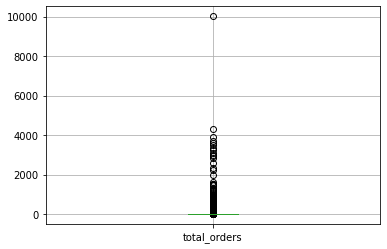

In [30]:
user_profile[['total_orders']].boxplot()
plt.title = "Количество заказов каждого пользователя"

Чего и следовало ожидать, у всех большинства пользователей < 2000 заказов. ОТ 2000 до 4000 не сильно много но тоже есть и только у одного 10000, возможно это перекупы которые очень сильно портят статистику, чтобы её поправить оставим данные не выше 99 процентиля.

count    21391.000000
mean         6.406760
std         13.961665
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        149.000000
Name: total_orders, dtype: float64


<AxesSubplot:>

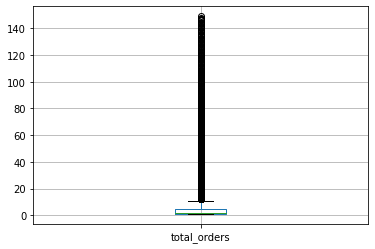

In [31]:
user_profile = user_profile[user_profile['total_orders'] <= user_profile['total_orders'].quantile(0.99)]

print(user_profile['total_orders'].describe())
user_profile[['total_orders']].boxplot()

Чтож теперь данные больше похожи на правду. Проверим показатели среднего количества билетов в заказе

count    21391.000000
mean         2.751423
std          0.927392
min          1.000000
25%          2.000000
50%          2.750000
75%          3.142857
max         11.000000
Name: avg_tickets, dtype: float64


<AxesSubplot:>

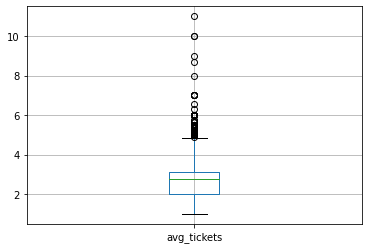

In [32]:
print(user_profile['avg_tickets'].describe())
user_profile[['avg_tickets']].boxplot()

Данные очень хорошие есть редкие значения но они находятся в допустимом диапазоне. Маленькое стандартное отклонение говорит о высокой концентрации данных вокруг среднего значения.

count    13206.000000
mean        16.258810
std         22.547520
min          0.000000
25%          1.369159
50%          8.500000
75%         21.000000
max        148.000000
Name: avg_days_between, dtype: float64


<AxesSubplot:>

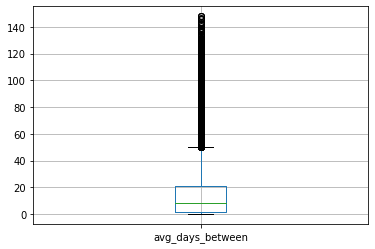

In [33]:
print(user_profile['avg_days_between'].describe())
user_profile[['avg_days_between']].boxplot()

Аномалий нет, менее 10_000 пользователей сделали покупки лишь однажды, а остальные с периодичностью от 0 до 148 дней. Пересчитаем показатели с учётом поправок.

In [34]:
print(f"Всего пользователей: {len(user_profile)}")
print(f"Cредняя выручка с одного заказа:", user_profile["avg_revenue_rub"].mean())

print(f"Доля пользователей, совершивших 2 и более заказа: {len(user_profile[user_profile['is_two']==1])/len(user_profile)}")
print(f"Доля пользователей, совершивших 5 и более заказа: {len(user_profile[user_profile['is_five']==1])/len(user_profile)}")

Всего пользователей: 21391
Cредняя выручка с одного заказа: 583.4483949003621
Доля пользователей, совершивших 2 и более заказа: 0.33098031882567436
Доля пользователей, совершивших 5 и более заказа: 0.28240848955168063


Данные сильных изменений не претерпели и по итогу из 21391 пользователей средняя выручка 583 рубля, 33% из них покупали 2 и более раз 28% более 4 и всё теже 49% тоько 1 раз.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [35]:
# Изучим сегмент пользователей сгруппированный по типу их первого мероприятия

first_event = user_profile.groupby(['first_event_type']).agg({'user_id':'count'}).reset_index()
first_event['percent'] = first_event['user_id']/len(user_profile)*100
first_event = first_event.sort_values(by='percent', ascending = False)
print(first_event)

  first_event_type  user_id    percent
2         концерты     9416  44.018512
1           другое     5273  24.650554
5            театр     4299  20.097237
4          стендап     1124   5.254546
3            спорт      769   3.594970
0         выставки      413   1.930719
6             ёлки       97   0.453462


Результаты поражают 44% пользователей покупали билеты на концерты 24,6% на другое и 20% в театры. Из этих данных напрашивается вывод что концерты - тип мероприятий с наибольшим оборотом посетителей.

In [36]:
# Изучим сегмент пользователей сгруппированный по типу устройства, с которого совершена первая покупка


type_device = user_profile.groupby(['first_device']).agg({'user_id':'count'}).reset_index()
type_device['percent'] = type_device['user_id']/len(user_profile)*100

type_device = type_device.sort_values(by='percent', ascending = False)
print(type_device)

  first_device  user_id    percent
1       mobile    17740  82.932074
0      desktop     3651  17.067926


Данные говорят что почти 83% пользователей оформило первый заказ с телефона. Думаю это вполне логично так как мобильный телефон удобнее компьютера и всегда под рукой.

In [37]:
# Изучим сегмент пользователей сгруппированный по региону проведения мероприятия из первого заказа


type_region = user_profile.groupby(['first_region']).agg({'user_id':'count'}).reset_index()
type_region['percent'] = type_region['user_id']/len(user_profile)*100
print(type_region.sort_values(by='percent', ascending = False))

                first_region  user_id    percent
23        Каменевский регион     7039  32.906362
60      Североярская область     3808  17.801879
77       Широковская область     1249   5.838904
45          Озернинский край      686   3.206956
41      Малиновоярский округ      543   2.538451
..                       ...      ...        ...
17            Залесский край        2   0.009350
70       Тихогорская область        2   0.009350
5          Верхозёрский край        1   0.004675
66  Сосноводолинская область        1   0.004675
80        Яснопольский округ        1   0.004675

[81 rows x 3 columns]


Итак флагманом оказался Каменевский регион с ~ 33% всех заказов. Возможно там живёт больше всего пользователей Яндекс Афиши либо там проходило наибольшее количество мероприятий.

In [38]:
# Изучим сегмент пользователей сгруппированный по билетному оператору, продавшему билеты на первый заказ.


type_service = user_profile.groupby(['first_service']).agg({'user_id':'count'}).reset_index()
type_service['percent'] = type_service['user_id']/len(user_profile)*100
print(type_service.sort_values(by='percent', ascending = False).head(5))

         first_service  user_id    percent
3   Билеты без проблем     4973  23.248095
19         Лови билет!     2826  13.211164
22           Мой билет     2778  12.986770
4        Билеты в руки     2557  11.953625
23             Облачко     2216  10.359497


Чаще всего люди пользуются сервисом "Билеты без проблем" 23%.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

1- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [39]:
#теперь к каждому сегменту нужно добавить поле отвечающее за совершение повторного заказа
repeating_users = user_profile[user_profile['total_orders'] > 1].groupby('first_event_type')['user_id'].count()

first_event = first_event.merge(repeating_users.rename('povtor'), left_on='first_event_type', right_index=True, how='left')

In [40]:
#Для удобства выводим доли вернувшихся в процентах
first_event['povt_prerc'] = first_event['povtor']/first_event['user_id']*100

print(first_event)

  first_event_type  user_id    percent  povtor  povt_prerc
2         концерты     9416  44.018512    5812   61.724724
1           другое     5273  24.650554    3144   59.624502
5            театр     4299  20.097237    2736   63.642708
4          стендап     1124   5.254546     686   61.032028
3            спорт      769   3.594970     424   55.136541
0         выставки      413   1.930719     265   64.164649
6             ёлки       97   0.453462      54   55.670103


Из данных видно что на все виды развлеченй от 55 до 64 % люди приходят повторно, но в числовом выражении этот показатель варьируется от 5812 для концертов до 54 для ёлок. Для большей наглядности построим график.

<AxesSubplot:title={'center':'Распределение повторных покупок в разрезе мероприятий'}, xlabel='Мероприятие', ylabel='Процент повторных заказов'>

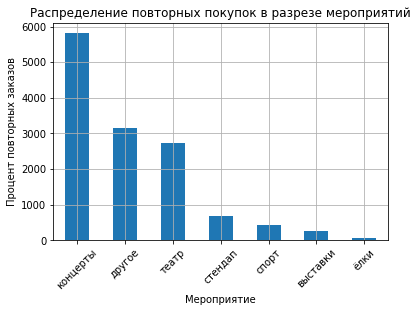

In [41]:
first_event.plot(kind='bar', x = 'first_event_type', 
                 y = 'povtor', rot=45, 
                 title= "Распределение повторных покупок в разрезе мероприятий",
                 xlabel = "Мероприятие",
                 ylabel = "Процент повторных заказов",
                 grid = True,
                 legend = False
                )


Как ранее и говорилось в процентном соотношении лидеры (выставки 64%) и замыкающие (спорт 55%) имеют сравнительно небольшой разрыв. Теперь проделаем те же действия для остальных сигментов. Но беря во внимание что на концерты повторно купило билеты 5812 человек (61%), то сразу становится ясно что именно концерты являются "точкой входа"   

In [42]:
# Рассмотрим вернувшихся пользователей в разрезе устройства первого заказа

repeating_users = user_profile[user_profile['total_orders'] > 1].groupby('first_device')['user_id'].count()

type_device = type_device.merge(repeating_users.rename('povtor'), left_on='first_device', right_index=True, how='left')

#Для удобства выводим доли вернувшихся в процентах
type_device['povt_prerc'] = type_device['povtor']/type_device['user_id']*100

print(type_device)

  first_device  user_id    percent  povtor  povt_prerc
1       mobile    17740  82.932074   10808   60.924464
0      desktop     3651  17.067926    2313   63.352506


Чтож как и в разрезе мероприятий получется что в процентном соотношении повторных заказов показатели примерно равны 63% для десктопных устройств и 61% для мобильных, НО в количестве пользователей для мобильных устройств это 10808 клиентов с повторным заказом тогда как для пк всего 2313.

<AxesSubplot:title={'center':'Распределение повторных покупок в разрезе устройств'}, xlabel='Устройства', ylabel='Процент повторных заказов'>

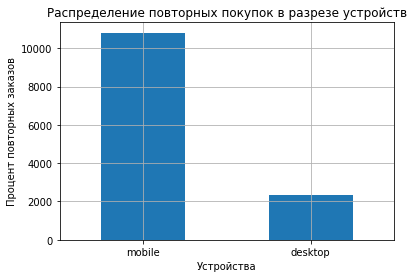

In [43]:
type_device.sort_values(by='povtor', ascending = False).plot(kind='bar', x = 'first_device', 
                 y = 'povtor', 
                 title= "Распределение повторных покупок в разрезе устройств",
                 xlabel = "Устройства",rot = 0,
                 ylabel = "Процент повторных заказов",
                 grid = True,
                 legend = False
                )

Интересно, пользователи совершившие заказ с мобильного телефона с примерно той же вероятностью совершают повторный заказ что и покупающие билеты с пк, но всё же мобильные устройства выйгрывают по количеству пользователей поэтому именно они являются наиболее перспективными.

In [44]:
# Рассмотрим вернувшихся пользователей в разрезе региона

repeating_users = user_profile[user_profile['total_orders'] > 1].groupby('first_region')['user_id'].count()

type_region = type_region.merge(repeating_users.rename('povtor'), left_on='first_region', right_index=True, how='left')

#Для удобства выводим доли вернувшихся в процентах
type_region['povt_prerc'] = type_region['povtor']/type_region['user_id']*100

type_region = type_region.sort_values(by='povtor', ascending = False)

print(type_region)

                first_region  user_id    percent  povtor  povt_prerc
23        Каменевский регион     7039  32.906362  4371.0   62.096889
60      Североярская область     3808  17.801879  2453.0   64.417017
77       Широковская область     1249   5.838904   810.0   64.851882
45          Озернинский край      686   3.206956   379.0   55.247813
57      Светополянский округ      472   2.206535   314.0   66.525424
..                       ...      ...        ...     ...         ...
32       Крутоводский регион        3   0.014025     1.0   33.333333
5          Верхозёрский край        1   0.004675     1.0  100.000000
17            Залесский край        2   0.009350     1.0   50.000000
66  Сосноводолинская область        1   0.004675     NaN         NaN
80        Яснопольский округ        1   0.004675     NaN         NaN

[81 rows x 5 columns]


Видно что по количеству повторных покупок лидирует  Каменевский регион с 4371 клиентом совершившим повторный заказ. Посмотрим на топ 10

<AxesSubplot:title={'center':'Распределение повторных покупок в разрезе регионов'}, ylabel='регион'>

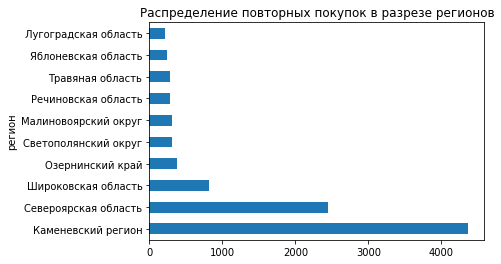

In [45]:
type_region.head(10).plot(kind='barh', x = 'first_region', 
                 y = 'povtor', 
                 title= "Распределение повторных покупок в разрезе регионов",
                 xlabel = "регион",rot = 0,
                 ylabel = "Количество повторных заказов",
                 legend = False
                )

В данной конфигурации данные показывают что точка входа Каменевский регион. На втором месте Североярская область с 2453 вернувшимися клиентами, а остальные имеют примерно одинаково малые значения.

In [46]:
# Рассмотрим вернувшихся пользователей в разрезе первого сервиса

repeating_users = user_profile[user_profile['total_orders'] > 1].groupby('first_service')['user_id'].count()

type_service = type_service.merge(repeating_users.rename('povtor'), left_on='first_service', right_index=True, how='left')

#Для удобства выводим доли вернувшихся в процентах
type_service['povt_prerc'] = type_service['povtor']/type_service['user_id']*100

type_service = type_service.sort_values(by='povtor', ascending = False)

print(type_service.head(5))

         first_service  user_id    percent  povtor  povt_prerc
3   Билеты без проблем     4973  23.248095    2993   60.184999
19         Лови билет!     2826  13.211164    1736   61.429582
22           Мой билет     2778  12.986770    1645   59.215263
4        Билеты в руки     2557  11.953625    1614   63.120845
23             Облачко     2216  10.359497    1368   61.732852


Явный лидер сервис "Билеты без проблем" с почти 3000 вернувшихся пользователей.

<AxesSubplot:title={'center':'Распределение повторных покупок в разрезе сервисов'}, ylabel='Cервис'>

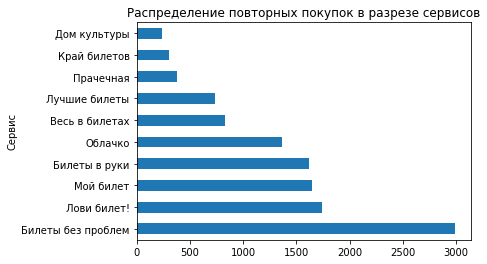

In [47]:
type_service.head(10).plot(kind='barh', x = 'first_service', 
                 y = 'povtor', 
                 title= "Распределение повторных покупок в разрезе сервисов",
                 xlabel = "Cервис",rot = 0,
                 ylabel = "Количество повторных заказов",
                 legend = False
                )

График показывает нам что сервис "Билеты без проблем" по количеству вернувшихся пользователей преобладает над остальными сервисами почти в 2 раза. Возможно у них хорошая реклама и быстроработающая платформа ориентированная на мобильные устройства

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [48]:
# Проверим гипотезу 1
hypothesis_1 = first_event[['first_event_type', 'povtor','povt_prerc']].sort_values('povt_prerc', ascending=False)
print("Рейтинг типов мероприятий по доле повторных заказов:")
print(hypothesis_1)

Рейтинг типов мероприятий по доле повторных заказов:
  first_event_type  povtor  povt_prerc
0         выставки     265   64.164649
5            театр    2736   63.642708
2         концерты    5812   61.724724
4          стендап     686   61.032028
1           другое    3144   59.624502
6             ёлки      54   55.670103
3            спорт     424   55.136541


Гипотеза НЕ ПОДТВЕРЖДАЕТСЯ. Спортивные мероприятия имеют самую низкую долю повторных заказов (55.1%) среди всех категорий, тогда как концерты показывают средний результат (61.7%). Лидерами являются выставки (64.2%) и театр (63.6%)

In [49]:
# Проверим гипотезу 2

# Сравним топ-5 регионов по количеству пользователей с остальными
top_regions = type_region.head(5)
other_regions = type_region.iloc[5:]

avg_repeat_top = top_regions['povt_prerc'].mean()
avg_repeat_other = other_regions['povt_prerc'].mean()

print(f"Средняя доля повторных заказов в топ-5 регионах: {avg_repeat_top:.2f}%")
print(f"Средняя доля повторных заказов в остальных регионах: {avg_repeat_other:.2f}%")
print(f"Разница: {avg_repeat_top - avg_repeat_other:.2f}%")

# Проверим статистическую значимость
from scipy import stats
t_stat, p_value = stats.ttest_ind(top_regions['povt_prerc'].dropna(), 
                                 other_regions['povt_prerc'].dropna())
print(f"p-value: {p_value:.4f}")

Средняя доля повторных заказов в топ-5 регионах: 62.63%
Средняя доля повторных заказов в остальных регионах: 56.82%
Разница: 5.81%
p-value: 0.2744


Гипотеза ЧАСТИЧНО ПОДТВЕРЖДАЕТСЯ. Крупные регионы действительно показывают стабильно высокие абсолютные показатели повторных заказов, но в процентном соотношении разница незначительнай. Но поскольку p-value > 0.05 — различия не являются статистически значимыми (могли возникнуть случайно). 

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---


**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [50]:
# Разделяем пользователей на две группы
one_time_users = user_profile[user_profile['total_orders'] == 1]['avg_revenue_rub']
returning_users = user_profile[user_profile['total_orders'] >= 2]['avg_revenue_rub']

print(f"Однократные пользователи: {len(one_time_users)} чел.")
print(f"Вернувшиеся пользователи: {len(returning_users)} чел.")

Однократные пользователи: 8270 чел.
Вернувшиеся пользователи: 13121 чел.


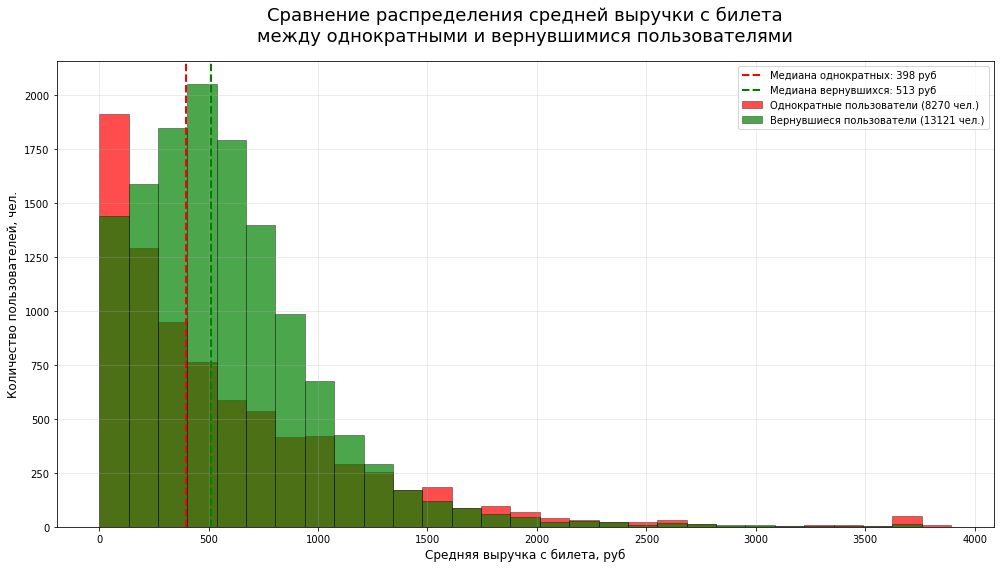


СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ
       Однократные пользователи  Вернувшиеся пользователи
count                  8270.000                 13121.000
mean                    588.134                   580.495
std                     605.447                   423.974
min                       0.070                     0.352
25%                     150.512                   287.595
50%                     397.870                   512.880
75%                     852.445                   772.390
max                    3891.660                  3698.830


In [51]:
import matplotlib.pyplot as plt
# Создаем фигуру и оси
plt.figure(figsize=(14, 8))

# Определяем общие бины для корректного сравнения
all_data = pd.concat([one_time_users, returning_users])
bins = np.linspace(all_data.min(), all_data.max(), 30)

# Строим гистограммы для обеих групп
plt.hist(one_time_users, bins=bins, alpha=0.7, color='red', 
         label=f'Однократные пользователи ({len(one_time_users)} чел.)', 
         edgecolor='black', linewidth=0.5)

plt.hist(returning_users, bins=bins, alpha=0.7, color='green', 
         label=f'Вернувшиеся пользователи ({len(returning_users)} чел.)', 
         edgecolor='black', linewidth=0.5)

# Настраиваем оформление графика
plt.xlabel('Средняя выручка с билета, руб', fontsize=12)
plt.ylabel('Количество пользователей, чел.', fontsize=12)
plt.title('Сравнение распределения средней выручки с билета\nмежду однократными и вернувшимися пользователями', 
          fontsize=18, pad=20)

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Добавляем информацию о медианах
median_one_time = one_time_users.median()
median_returning = returning_users.median()

plt.axvline(median_one_time, color='red', linestyle='--', linewidth=2, 
            label=f'Медиана однократных: {median_one_time:.0f} руб')
plt.axvline(median_returning, color='green', linestyle='--', linewidth=2, 
            label=f'Медиана вернувшихся: {median_returning:.0f} руб')

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Выводим статистику
print("\n" + "="*60)
print("СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ")
print("="*60)

stats_df = pd.DataFrame({
    'Однократные пользователи': one_time_users.describe(),
    'Вернувшиеся пользователи': returning_users.describe()
})
print(stats_df.round(3))


Из графика и данных можно сделать несколько выводов:
- Среди пользователей с одни заказом чётко виден тренд согласно которому чем дороже билет тем меньше людей его купит.
- График вернувшихся пользователей больше смещён вправо, медиана больше чем у не вернувшихся из этого делаем вывод что пользователи совершающие повторные покупки  в среднем покупают более дорогие билеты
- На удивление средняя выручка у обеих групп не сильно отличается. 588 - для однократных пользователей и 580 для вернувшихся, но при этом стандартное отклонение и 75 процентиль у вернувшихся пользователей меньше, значит у них показатели более сконцентрированы.


---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [52]:
# Разделяем пользователей на две группы
two_time = user_profile[user_profile['is_two'] == 1]['avg_revenue_rub']
five_time = user_profile[user_profile['is_five'] ==1]['avg_revenue_rub']

print(f"2 и более заказов: {len(two_time)} чел.")
print(f"5 и более заказов: {len(five_time)} чел.")

2 и более заказов: 7080 чел.
5 и более заказов: 6041 чел.


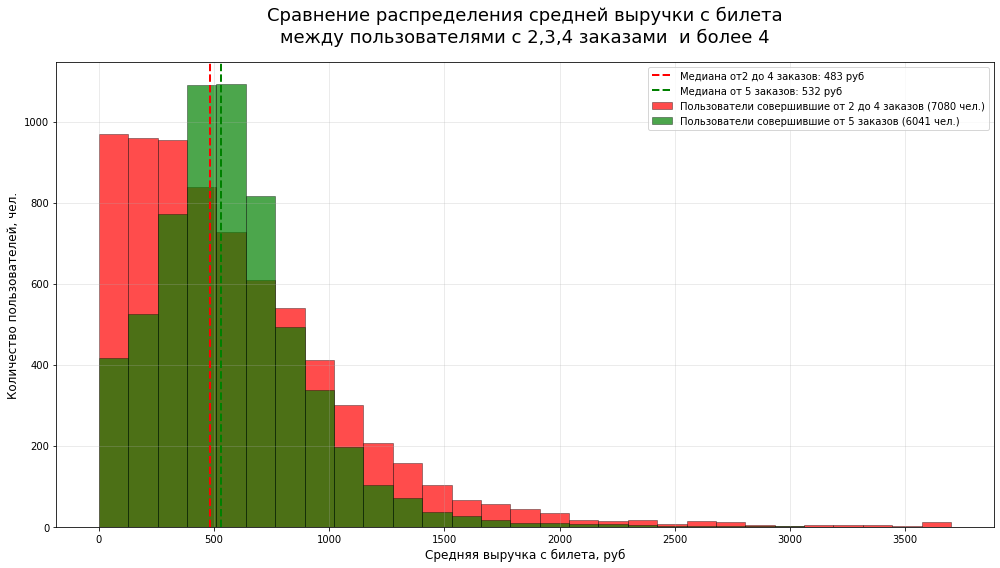


СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ
       Пользователи с 2 и более заказами  Пользователи с 5 и более заказами
count                           7080.000                           6041.000
mean                             589.602                            569.822
std                              488.489                            332.533
min                                2.417                              0.352
25%                              234.521                            351.630
50%                              482.971                            531.610
75%                              822.396                            733.027
max                             3698.830                           2959.062


In [53]:
import matplotlib.pyplot as plt
# Создаем фигуру и оси
plt.figure(figsize=(14, 8))

# Определяем общие бины для корректного сравнения
all_data = pd.concat([two_time, five_time])
bins = np.linspace(all_data.min(), all_data.max(), 30)

# Строим гистограммы для обеих групп
plt.hist(two_time, bins=bins, alpha=0.7, color='red', 
         label=f'Пользователи совершившие от 2 до 4 заказов ({len(two_time)} чел.)', 
         edgecolor='black', linewidth=0.5)

plt.hist(five_time, bins=bins, alpha=0.7, color='green', 
         label=f'Пользователи совершившие от 5 заказов ({len(five_time)} чел.)', 
         edgecolor='black', linewidth=0.5)

# Настраиваем оформление графика
plt.xlabel('Средняя выручка с билета, руб', fontsize=12)
plt.ylabel('Количество пользователей, чел.', fontsize=12)
plt.title('Сравнение распределения средней выручки с билета\nмежду пользователями с 2,3,4 заказами  и более 4', 
          fontsize=18, pad=20)

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Добавляем информацию о медианах
median_one_time = two_time.median()
median_returning = five_time.median()

plt.axvline(median_one_time, color='red', linestyle='--', linewidth=2, 
            label=f'Медиана от2 до 4 заказов: {median_one_time:.0f} руб')
plt.axvline(median_returning, color='green', linestyle='--', linewidth=2, 
            label=f'Медиана от 5 заказов: {median_returning:.0f} руб')

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Выводим статистику
print("\n" + "="*60)
print("СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ")
print("="*60)

stats_df = pd.DataFrame({
    'Пользователи с 2 и более заказами': two_time.describe(),
    'Пользователи с 5 и более заказами': five_time.describe()
})
print(stats_df.round(3))


Удивительно но средняя выручка у обеих групп почти одинакова 589 для группы менее 5 заказов и 569 для группы от 5 заказов. Также стоит обратить внимение на огромный хвост первой группы - он означает что хоь большинство в среднемпокупет наиболее дешёвые билеты, есть люди совершающие более дорогие покупки. Для группы с долее чем 5 заказами хвост тоже присутствует, но оказывает гораздо меньшее воздействие на статистические показатели. Опять же данные у второй группы более концентрированы (вокруг отметки 500 руб). Пик первой группы приходится на показатели от 0 до 375 рублей

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [54]:

# Создаем сегменты по количеству билетов
bins = [1, 2, 3, 5, user_profile['avg_tickets'].max() + 1]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']
user_profile['tickets_segment'] = pd.cut(user_profile['avg_tickets'], bins=bins, labels=labels, right=False)

# Анализ сегментов
segment_stats = user_profile.groupby('tickets_segment').agg({
    'user_id': 'count',
    'total_orders': ['mean', lambda x: (x >= 2).mean()],
    'avg_revenue_rub': 'median'
}).round(2)

# Переименовываем столбцы
segment_stats.columns = ['total_users', 'avg_orders', 'repeat_rate', 'median_revenue']
segment_stats['repeat_rate'] = (segment_stats['repeat_rate'] * 100).round(1)
segment_stats['user_share'] = (segment_stats['total_users'] / len(user_profile) * 100).round(1)

print("АНАЛИЗ СЕГМЕНТОВ ПО КОЛИЧЕСТВУ БИЛЕТОВ")
print("="*50)
print(segment_stats)

АНАЛИЗ СЕГМЕНТОВ ПО КОЛИЧЕСТВУ БИЛЕТОВ
                 total_users  avg_orders  repeat_rate  median_revenue  \
tickets_segment                                                         
1-2 билета              2397        2.69         51.0          208.27   
2-3 билета              9324        9.97         73.0          466.96   
3-5 билетов             8990        4.08         55.0          627.51   
5+ билетов               680        1.40         20.0          714.13   

                 user_share  
tickets_segment              
1-2 билета             11.2  
2-3 билета             43.6  
3-5 билетов            42.0  
5+ билетов              3.2  


Из данных видно что в сегменте 2-3 билета больше всего людей и самое высокое число билетов на человека 9.97. Для большей наглядности необходимо отбразить самые важные показатели на графиках

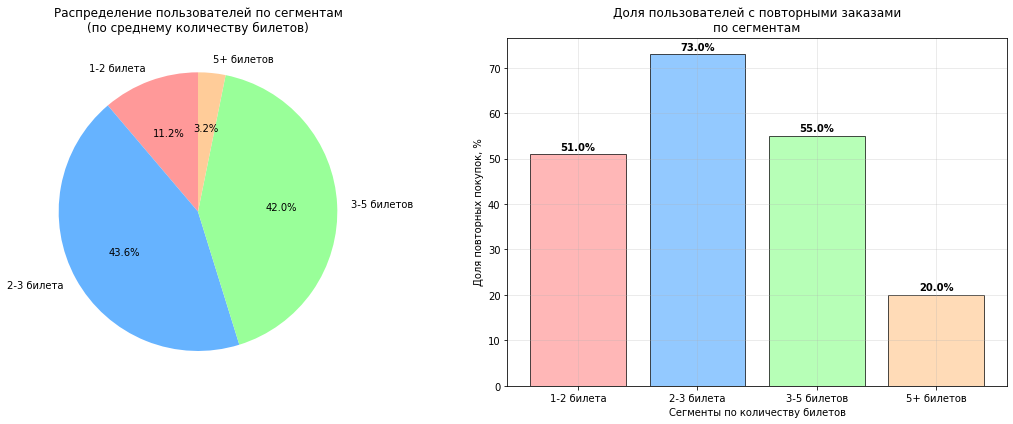

In [55]:

# ВИЗУАЛИЗАЦИЯ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График 1: Распределение пользователей по сегментам (круговая диаграмма)
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
ax1.pie(segment_stats['total_users'], labels=segment_stats.index, 
        autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Распределение пользователей по сегментам\n(по среднему количеству билетов)')

# График 2: Доля повторных покупок по сегментам (столбчатая диаграмма)
bars = ax2.bar(segment_stats.index, segment_stats['repeat_rate'], 
               color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Сегменты по количеству билетов')
ax2.set_ylabel('Доля повторных покупок, %')
ax2.set_title('Доля пользователей с повторными заказами\nпо сегментам')
ax2.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar, value in zip(bars, segment_stats['repeat_rate']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{value}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


Распределение пользователей такого: 43% и 42% купили 2-3 и 3-5 билетов соответсвенно. Тоесть на два сегмента уже приходится 85% всех данных. 1-2 билета купили 11%, а 5+ билетов только 3%. По значениям анамально мало человек из сегмента 5+ купили повторно билеты это может означать что 80% людей из данного сектора разово закупали билеты на коллектив. 2-3 билета очень много 73% повторных покупок возможно это наиболее удобный формат для пары/семьи. Остальные данные близки к 50% и подозрений не вызывают.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [56]:

# 1. Извлекаем день недели из даты первого заказа
user_profile['first_weekday'] = user_profile['first_order_dt'].dt.day_name()

# Создаем правильный порядок дней недели
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
user_profile['first_weekday'] = pd.Categorical(user_profile['first_weekday'], 
                                              categories=weekday_order, 
                                              ordered=True)

# 2. Анализируем по дням недели
weekday_stats = user_profile.groupby('first_weekday').agg({
    'user_id': 'count',
    'total_orders': lambda x: (x >= 2).mean()
}).round(4)

weekday_stats.columns = ['total_users', 'repeat_rate']
weekday_stats['repeat_rate'] = (weekday_stats['repeat_rate'] * 100).round(1)
weekday_stats['user_share'] = (weekday_stats['total_users'] / len(user_profile) * 100).round(1)

print("АНАЛИЗ ВЛИЯНИЯ ДНЯ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ")
print("="*60)
print(weekday_stats)


АНАЛИЗ ВЛИЯНИЯ ДНЯ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ
               total_users  repeat_rate  user_share
first_weekday                                      
Monday                2860         62.7        13.4
Tuesday               3083         61.4        14.4
Wednesday             3035         61.9        14.2
Thursday              3096         60.0        14.5
Friday                3256         60.2        15.2
Saturday              3294         62.8        15.4
Sunday                2767         60.4        12.9


На первый взгляд выдающихся дней нет и значения колеблются около 61% а доля людей совершивших первый заказ в каждый день была разная и явный лидер - суббота.

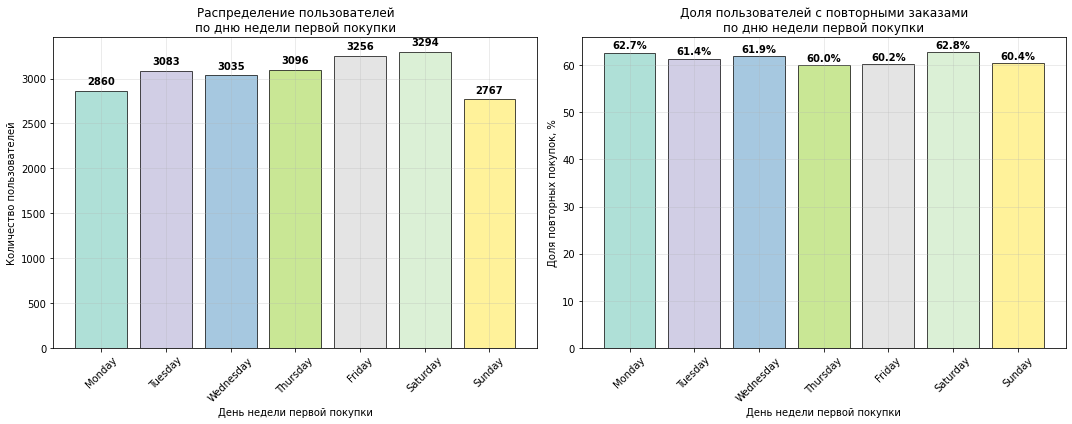

In [57]:
# 3. Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График 1: Распределение пользователей по дням недели
colors = plt.cm.Set3(np.linspace(0, 1, 7))
bars1 = ax1.bar(weekday_stats.index, weekday_stats['total_users'], color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('День недели первой покупки')
ax1.set_ylabel('Количество пользователей')
ax1.set_title('Распределение пользователей\nпо дню недели первой покупки')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar, value in zip(bars1, weekday_stats['total_users']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{value}', ha='center', va='bottom', fontweight='bold')

# График 2: Доля повторных покупок по дням недели
bars2 = ax2.bar(weekday_stats.index, weekday_stats['repeat_rate'], color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('День недели первой покупки')
ax2.set_ylabel('Доля повторных покупок, %')
ax2.set_title('Доля пользователей с повторными заказами\nпо дню недели первой покупки')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar, value in zip(bars2, weekday_stats['repeat_rate']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{value}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Как и ожидалось результаты примерно одинаковы, самый лучший день недели всё-таки суббота т.к. в этот день больше всего пользователей совершили первый заказ (3294) и больше всего пользователей сделали его повторно 62.8%. Оно и логично в не рабочие дни люди меньше думают о должностных обязанностях и думают о том как провести время, видимо в этот момент они заходят на яндекс афишу.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [58]:
#Делим на группы
group_2_4 = user_profile[user_profile['is_two'] == 1]
group_5_plus = user_profile[user_profile['is_five'] == 1]


# Анализируем среднее время между заказами для обеих групп
days_stats = pd.DataFrame({
    '2-4 заказа': group_2_4['avg_days_between'].describe(),
    '5+ заказов': group_5_plus['avg_days_between'].describe()
}).round(2)

print("СТАТИСТИКА СРЕДНЕГО ВРЕМЕНИ МЕЖДУ ЗАКАЗАМИ")
print("="*60)
print(days_stats)

СТАТИСТИКА СРЕДНЕГО ВРЕМЕНИ МЕЖДУ ЗАКАЗАМИ
       2-4 заказа  5+ заказов
count     7080.00     6041.00
mean        21.34        9.93
std         28.46        7.81
min          0.00        0.00
25%          0.00        3.92
50%          9.00        8.17
75%         33.67       14.20
max        148.00       37.50


По данным видно что для сегмента 2-4 заказа (7080 человек) среднее 21 день НО есть большое стандартное отклонение которое говорит о неком разбросе данных. Для группы 5+ (6041 человек)наоборот разброс меньше и меньше среднее значит данные более концентрированны.

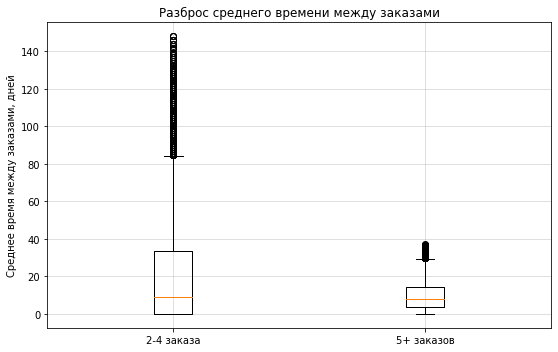

In [59]:
# 3. Визуализация распределений
plt.figure(figsize=(15, 5))
# Боксплоты
plt.subplot(1, 2, 2)
box_data = [group_2_4['avg_days_between'], group_5_plus['avg_days_between']]
plt.boxplot(box_data, labels=['2-4 заказа', '5+ заказов'])
plt.ylabel('Среднее время между заказами, дней')
plt.title('Разброс среднего времени между заказами')
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

Итак, тепперь видно что у сегмента 2-4 заказа невероятно большой "хвост". Чаще всего люди в этом сегменте делают несколько заказов в день но есть небольшая доля пользователей которая готова подождать от 0 до 148 дней. Для группы 5+ заказов также характерна моментальность решений и ждать они готовы от 0 до 40 дней.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [60]:
!pip install phik
from phik import phik_matrix
import seaborn as sns

interval columns not set, guessing: ['avg_revenue_rub', 'avg_tickets', 'avg_days_between', 'total_orders']


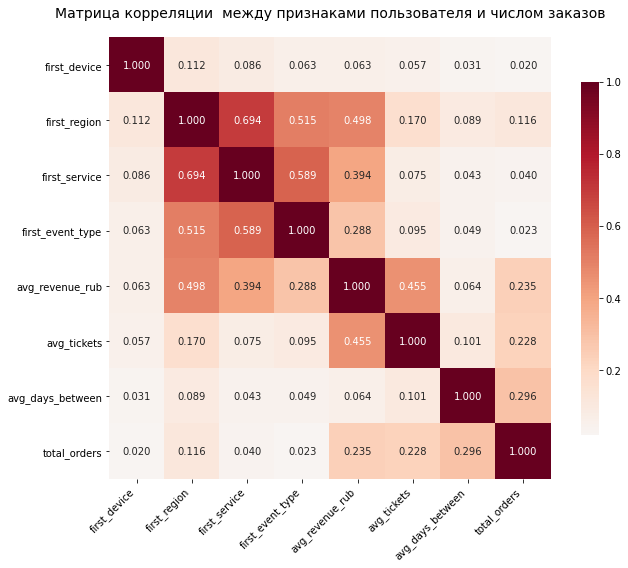


КОРРЕЛЯЦИИ ПРИЗНАКОВ С СЕГМЕНТАМИ ПО КОЛИЧЕСТВУ ЗАКАЗОВ
                  correlation_with_orders
total_orders                     1.000000
avg_days_between                 0.296078
avg_revenue_rub                  0.234908
avg_tickets                      0.227565
first_region                     0.115712
first_service                    0.039969
first_event_type                 0.022555
first_device                     0.019547


In [61]:
# Создаем корректные признаки для анализа
# Подготовка данных для корреляционного анализа
features_for_correlation = [
    'first_device',           # категориальный
    'first_region',           # категориальный  
    'first_service',          # категориальный
    'first_event_type',       # категориальный
    'avg_revenue_rub',        # числовой
    'avg_tickets',            # числовой
    'avg_days_between',    # бинарный (заменяет проблемный avg_days_between)
    'total_orders'          # целевая переменная
]

# Создаем датафрейм для анализа
correlation_data = user_profile[features_for_correlation].copy()


# 4. Рассчитываем матрицу корреляции phi_k
phi_k_matrix = correlation_data.phik_matrix()


# 5. Визуализируем тепловую карту корреляций
plt.figure(figsize=(10, 8))

sns.heatmap(phi_k_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='RdBu_r', 
            center=0,
            square=True,
            cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляции  между признаками пользователя и числом заказов', 
          fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 6. Анализ корреляций с целевой переменной
target_correlations = phi_k_matrix[['total_orders']].sort_values('total_orders', ascending=False)
target_correlations.columns = ['correlation_with_orders']

print("\n" + "="*70)
print("КОРРЕЛЯЦИИ ПРИЗНАКОВ С СЕГМЕНТАМИ ПО КОЛИЧЕСТВУ ЗАКАЗОВ")
print("="*70)
print(target_correlations)




Из данных видна средняя положительная связь total_orders с avg_days_between, avg_revenue_rub и avg_tickets. Т.е. чем выше стоимость заказа и больше билетов куплено, тем больше человек сделает заказов (что в целом логично) и также количество заказов растёт с промежутком дней между заказами. 

In [62]:
# Создаем бинарные признаки для каждого сегмента
user_profile['segment_1_order'] = (user_profile['total_orders'] == 1).astype(int)
user_profile['segment_2_4_orders'] = user_profile['is_two']
user_profile['segment_5_plus_orders'] = user_profile['is_five']

# Подготовка данных для корреляционного анализа
features_for_correlation = [
    'first_device',              # категориальный
    'first_region',              # категориальный  
    'first_service',             # категориальный
    'first_event_type',          # категориальный
    'avg_revenue_rub',           # числовой
    'avg_tickets',               # числовой
    'avg_days_between',          # числовой
    'segment_1_order',           # сегмент 1 заказ
    'segment_2_4_orders',        # сегмент 2-4 заказа  
    'segment_5_plus_orders'      # сегмент 5+ заказов
]

# Создаем датафрейм для анализа
correlation_data = user_profile[features_for_correlation].copy()

# Рассчитываем матрицу корреляции phi_k
phi_k_matrix = correlation_data.phik_matrix()

interval columns not set, guessing: ['avg_revenue_rub', 'avg_tickets', 'avg_days_between', 'segment_1_order', 'segment_2_4_orders', 'segment_5_plus_orders']



КОРРЕЛЯЦИИ ПРИЗНАКОВ С КАЖДЫМ СЕГМЕНТОМ
                  segment_1_order  segment_2_4_orders  segment_5_plus_orders
first_device             0.027221            0.000000               0.033169
first_region             0.077623            0.025669               0.084530
first_service            0.056678            0.020507               0.063460
first_event_type         0.032563            0.016466               0.025906
avg_revenue_rub          0.281173            0.049546               0.322459
avg_tickets              0.391980            0.112599               0.377370
avg_days_between         0.160797            0.449002               0.468871


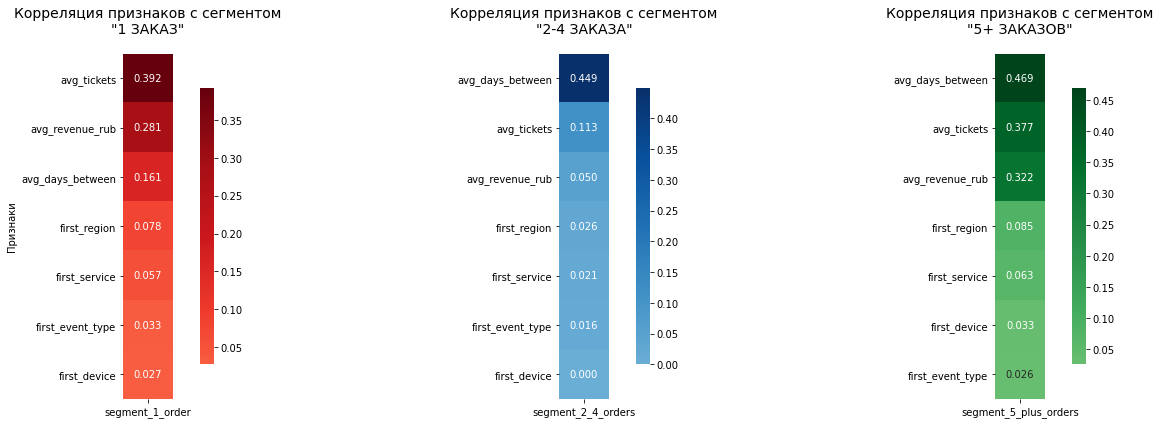

In [63]:

# 4. Выделяем корреляции с каждым сегментом
segment_correlations = phi_k_matrix[['segment_1_order', 'segment_2_4_orders', 'segment_5_plus_orders']]
segment_correlations = segment_correlations.drop(['segment_1_order', 'segment_2_4_orders', 'segment_5_plus_orders'])

print("\n" + "="*70)
print("КОРРЕЛЯЦИИ ПРИЗНАКОВ С КАЖДЫМ СЕГМЕНТОМ")
print("="*70)
print(segment_correlations)

# 5. Создаем три тепловые карты для каждого сегмента
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Сегмент 1: 1 заказ
sns.heatmap(segment_correlations[['segment_1_order']].sort_values('segment_1_order', ascending=False),
            annot=True, fmt='.3f', cmap='Reds', center=0, square=True, cbar_kws={'shrink': 0.8},
            ax=axes[0])
axes[0].set_title('Корреляция признаков с сегментом\n"1 ЗАКАЗ"', fontsize=14, pad=20)
axes[0].set_ylabel('Признаки')
axes[0].set_xlabel('')

# Сегмент 2: 2-4 заказа
sns.heatmap(segment_correlations[['segment_2_4_orders']].sort_values('segment_2_4_orders', ascending=False),
            annot=True, fmt='.3f', cmap='Blues', center=0, square=True, cbar_kws={'shrink': 0.8},
            ax=axes[1])
axes[1].set_title('Корреляция признаков с сегментом\n"2-4 ЗАКАЗА"', fontsize=14, pad=20)
axes[1].set_ylabel('')
axes[1].set_xlabel('')

# Сегмент 3: 5+ заказов
sns.heatmap(segment_correlations[['segment_5_plus_orders']].sort_values('segment_5_plus_orders', ascending=False),
            annot=True, fmt='.3f', cmap='Greens', center=0, square=True, cbar_kws={'shrink': 0.8},
            ax=axes[2])
axes[2].set_title('Корреляция признаков с сегментом\n"5+ ЗАКАЗОВ"', fontsize=14, pad=20)
axes[2].set_ylabel('')
axes[2].set_xlabel('')

plt.tight_layout()
plt.show()


СЕГМЕНТ "1 ЗАКАЗ" (Невернувшиеся):
Сильнее всего связаны: avg_tickets (0.392), avg_revenue_rub (0.281), avg_days_between (0.161)

- Пользователи с крупными разовыми покупками реже возвращаются

СЕГМЕНТ "2-4 ЗАКАЗА" (Умеренно лояльные):
Сильнее всего связаны: avg_days_between (0.449), avg_tickets (0.113)

- Регулярность покупок - ключевой фактор для этой группы

СЕГМЕНТ "5+ ЗАКАЗОВ" (Высоколояльные):
Сильнее всего связаны: avg_days_between (0.469), avg_tickets (0.377), avg_revenue_rub (0.322)

- Сочетание частоты, размера покупок и выручки характеризует самых лояльных клиентов

Неожиданный инсайт:
- Пользователи с одним заказом демонстрируют самые высокие корреляции с avg_tickets и avg_revenue_rub, что suggests что разовые крупные покупки могут быть барьером для возврата, либо это особые случаи (корпоративы, мероприятия).

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

Исходные данные и предобработка
- Объем данных: Изначально 290,611 записей о покупках, после обработки - 281,547 записей от 21,391 уникального пользователя

- Валютная унификация: Выручка приведена к российским рублям с использованием ежедневных курсов тенге

- Фильтрация данных: Удалены отрицательные значения выручки и экстремальные выбросы (выше 99-го перцентиля)

- Обработка пропусков: Пропуски в days_since_prev сохранены как информативные (означают первый заказ)

- Типизация данных: Оптимизированы типы данных для эффективной обработки

Ключевые результаты анализа
- Статистические показатели
- Средняя выручка с заказа: 583 рубля

Распределение по лояльности:

- 38.7% - однократные покупки

- 33.1% - 2-4 заказа

- 28.2% - 5+ заказов

Общая доля возврата: 61.3% пользователей совершили повторные заказы

Связь финансовых показателей с лояльностью
Выручка и лояльность:

- Вернувшиеся пользователи демонстрируют более сконцентрированное распределение выручки

- Медианная выручка выше у вернувшихся пользователей (513 руб vs 398 руб)

Количество билетов:

- Наиболее лояльный сегмент: 2-3 билета (73% возврата, 9.97 средних заказов)

- Проблемный сегмент: 5+ билетов (20% возврата) - вероятно, корпоративные/разовые покупки

Временные характеристики
День недели:

- Наибольшее количество первых покупок в субботу (15.4%)

- Наивысший возврат также в субботу (62.8%)

Интервалы между заказами:

- 2-4 заказа: 21.34 дня в среднем, высокий разброс

- 5+ заказов: 9.93 дня в среднем, стабильная частота

Корреляционный анализ
Сильнее всего с количеством заказов коррелируют:

- avg_days_between (0.296) - регулярность покупок

- avg_revenue_rub (0.235) - средняя выручка

- avg_tickets (0.228) - количество билетов

Сегментный анализ выявил:

- 1 заказ: Сильная связь с avg_tickets (0.392) - крупные разовые покупки

- 2-4 заказа: Ключевой фактор - avg_days_between (0.449)

- 5+ заказов: Комплексное влияние всех финансовых показателей

Рекомендации для бизнеса

Приоритетные направления развития
- Усилить продвижение концертов как основной "точки входа" (44% первых покупок)

- Развивать мобильный опыт (83% трафика), оптимизируя UX для повышения конверсии

+ Фокус на Каменевский регион как ключевой рынок с наибольшим потенциалом

Стратегии удержания клиентов
- Для сегмента 2-3 билета (наиболее лояльного): программы подписки и регулярных скидок

- Для пользователей с крупными разовыми покупками: специальные предложения для возврата

- Внедрить триггерные рассылки на основе поведения и предпочтений

Оптимизация продуктовой стратегии
- Разработать целевые предложения для разных ценовых сегментов

- Создать программы лояльности для частых покупателей (5+ заказов)

- Улучшить опыт групповых покупок для сегмента 5+ билетов

Маркетинговые инициативы
- Еженедельные акции в дни с высокой активностью (суббота)

- Партнерские программы с наиболее успешными билетными операторами

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**